In [79]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm.notebook import tqdm
import os
import pickle
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

BASE_DIR = 'flikr8k'
WORKING_DIR = 'saved'

In [80]:
with open(os.path.join(WORKING_DIR, 'mapping'), 'rb') as f:
    mapping = pickle.load(f)

with open(os.path.join(WORKING_DIR, 'tokenizer'), 'rb') as f:
    tokenizer = pickle.load(f)

In [81]:
from tensorflow import keras
model = keras.models.load_model(WORKING_DIR + '/best_model.h5')

In [82]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [83]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [84]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(img_path,features,max_length):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    # image_id = image_name.split('.')[0]
    # img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    # captions = mapping[image_id]
    print('---------------------Actual---------------------')
    # for caption in captions:
    #     print(caption)
    # predict the caption
    y_pred = predict_caption(model, features, tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [85]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

def extract_features(img_path):
    # load vgg16 model
    model = VGG16()

    # restructure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

    image = load_img(img_path, target_size=(224, 224))

    image = img_to_array(image)

    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    image = preprocess_input(image)

    features = model.predict(image, verbose=0)

    return features

In [91]:
features = extract_features('istockphoto-922289708-612x612.jpg')
features

array([[0.      , 0.      , 0.850192, ..., 0.      , 0.      , 0.      ]],
      dtype=float32)

---------------------Actual---------------------
--------------------Predicted--------------------
startseq boy in black shirt and black pants is walking on wooden beam endseq


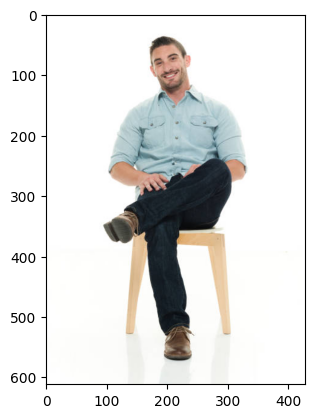

In [92]:
generate_caption("istockphoto-922289708-612x612.jpg",features,35)